## Access WRDS through Jupyter Notebook

In [1]:
import wrds
db = wrds.Connection(wrds_username='jniehaus21')
db.create_pgpass_file()

Loading library list...
Done
Enter your WRDS username [niehaus]:jniehaus21
Enter your password:········


In [2]:
#db.list_libraries()
#db.list_tables(library="crsp")
db.describe_table(library="crsp", table="monthly_tna_ret_nav")

Approximately 8123750 rows in crsp.monthly_tna_ret_nav.


,name,nullable,type
0,caldt,True,DATE
1,crsp_fundno,True,DOUBLE PRECISION
2,mtna,True,DOUBLE PRECISION
3,mret,True,DOUBLE PRECISION
4,mnav,True,DOUBLE PRECISION


In [3]:
#Download all available Total Net Asset data
data = db.get_table(library='crsp', table='monthly_tna_ret_nav', 
                    columns=['crsp_fundno', 'caldt', 'mtna', 'mret', 'mnav'])#, obs=100)
data.head()

,crsp_fundno,caldt,mtna,mret,mnav
0,NaN,1960-01-29,NaN,NaN,NaN
1,NaN,1960-02-29,NaN,NaN,NaN
2,NaN,1960-04-29,NaN,NaN,NaN
3,NaN,1960-06-30,NaN,NaN,NaN
4,NaN,1960-07-29,NaN,NaN,NaN


In [4]:
#Download all available Fund Summary data
data2 = db.get_table(library='crsp', table='fund_summary2', 
                    columns=['crsp_fundno', 'caldt', 'summary_period2', 'fund_name', 'lipper_class_name'])#, obs=100)
data2.head()

,crsp_fundno,caldt,summary_period2,fund_name,lipper_class_name
0,1.0,1997-12-31,A,AARP Income Tr:Bond for Income,None
1,1.0,1998-12-31,A,AARP Income Tr:Bond for Income,None
2,1.0,1999-03-31,Q,AARP Income Tr:Bond for Income,None
3,1.0,1999-06-30,Q,AARP Income Tr:Bond for Income,None
4,1.0,1999-09-30,Q,AARP Income Tr:Bond for Income,None


In [5]:
#print(data2.shape)
data2.dropna(subset=['lipper_class_name'], inplace=True)
#print(data2.shape)
scdf = data2[data2['lipper_class_name'].str.contains("Small-Cap Value")]
scdf.shape

(26945, 5)

In [6]:
#print(data.shape)
data.dropna(subset=['crsp_fundno'], inplace=True)
#data.shape

In [7]:
#Drop duplicates
t1 = scdf[['crsp_fundno', 'fund_name', 'lipper_class_name']].drop_duplicates()

#Merge tables
df = data.merge(t1, on='crsp_fundno', how='left')

In [8]:
#print(df.shape)
df.dropna(subset=['lipper_class_name'], inplace=True)
#print(df.shape)
df.dropna(subset=['mret'], inplace=True)
#print(df.shape)
df.dropna(subset=['mtna'], inplace=True)
#df.shape

In [10]:
#Annualize Return
df['annret'] = (1 + df['mret'])**12 - 1

#Remove mtna -99
tnamask = df['mtna'] > 0
mtna = df[tnamask]
#mtna.describe()

#Remove outliers
#mtna['mret'].describe()
retmask = mtna['mret'] < 0.9
out = mtna[retmask]
#out['mret'].describe()

In [12]:
#df.to_csv('SCVdata.csv', index=False)
df1 = out.groupby(['crsp_fundno', 'caldt']).head(1)
#df1.to_csv('SCVdropdup.csv', index=False)

In [13]:
#Create dictionary for fund_name
dict_lookup = df1[['crsp_fundno', 'fund_name']].drop_duplicates().set_index('crsp_fundno').to_dict()['fund_name']

#Groupby fundno, take average mtna, mret
funds = ['mtna', 'annret']
df2 = df1.groupby('crsp_fundno')[funds].mean().reset_index()
df2['fund_name'] = df2['crsp_fundno'].map(dict_lookup)
#df2.to_csv('SCVdataavg.csv', index=False)
df2.head()

,crsp_fundno,mtna,annret,fund_name
0,292.0,24.552966,0.091869,CitiFunds Trust II: CitiFunds Small Cap Value ...
1,479.0,24.468723,0.228712,The DLB Fund Group: DLB Enterprise III Fund
2,657.0,32.681614,0.225099,1838 Investment Advisors Funds: 1838 Small Cap...
3,671.0,78.500033,0.098062,Evergreen Select Equity Trust: Evergreen Selec...
4,709.0,22.941000,0.301803,"First American Investment Funds, Inc.: Regiona..."


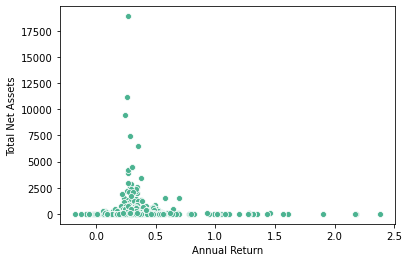

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df2, x="annret", y="mtna", color="#4CB391")
plt.xlabel('Annual Return')
plt.ylabel('Total Net Assets')
plt.show()

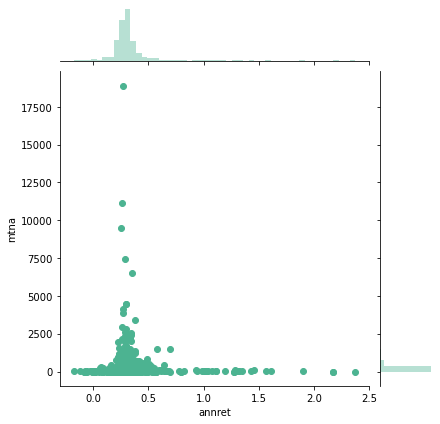

In [59]:
sns.jointplot(data=df2, x='annret', y='mtna', kind="scatter", color="#4CB391")
plt.show()

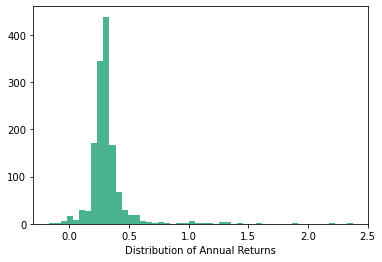

In [68]:
plt.hist(df2['annret'], bins=50, color="#4CB391")
#plt.title('Distribution of Annual Returns')
plt.xlabel('Distribution of Annual Returns')
plt.show()

In [16]:
df2['mtna'].describe()

count     1385.000000
mean       189.207619
std        788.024766
min          0.096786
25%          4.113559
50%         26.894869
75%        121.795034
max      18890.855341
Name: mtna, dtype: float64